In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

from keras.datasets import mnist

from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
print(x_test.shape)

x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

print(x_test.shape)

(10000, 784)
(10000, 784)


In [5]:
#normalize
x_train -= x_train.min()
x_train = x_train/x_train.max()

In [47]:
x = Input(shape=(784,))

enc_1 = Dense(150, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

dec_2 = Dense(150, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 150)               117750    
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 302       
_________________________________________________________________
dense_17 (Dense)             (None, 150)               450       
_________________________________________________________________
dense_18 (Dense)             (None, 784)               118384    
Total params: 236,886
Trainable params: 236,886
Non-trainable params: 0
_________________________________________________________________


In [48]:
autoencoder.compile(loss='mse', optimizer=Adam())
autoencoder.fit(x_train, x_train, batch_size=1024, epochs=60)

Epoch 1/60
60000/60000 [==============================] - 5s 88us/step - loss: 0.0999
Epoch 2/60
60000/60000 [==============================] - 3s 50us/step - loss: 0.0686
Epoch 3/60
60000/60000 [==============================] - 3s 50us/step - loss: 0.0679
Epoch 4/60
60000/60000 [==============================] - 3s 51us/step - loss: 0.0676
Epoch 5/60
60000/60000 [==============================] - 3s 51us/step - loss: 0.0675
Epoch 6/60
60000/60000 [==============================] - 3s 50us/step - loss: 0.0674
Epoch 7/60
60000/60000 [==============================] - 3s 51us/step - loss: 0.0674
Epoch 8/60
60000/60000 [==============================] - 3s 51us/step - loss: 0.0674
Epoch 9/60
60000/60000 [==============================] - 3s 51us/step - loss: 0.0674
Epoch 10/60
60000/60000 [==============================] - 3s 51us/step - loss: 0.0674
Epoch 11/60
60000/60000 [==============================] - 3s 50us/step - loss: 0.0673
Epoch 12/60
60000/60000 [===========================

In [49]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 150)               117750    
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 302       
Total params: 118,052
Trainable params: 118,052
Non-trainable params: 0
_________________________________________________________________


In [50]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 150)               450       
_________________________________________________________________
dense_18 (Dense)             (None, 784)               118384    
Total params: 118,834
Trainable params: 118,834
Non-trainable params: 0
_________________________________________________________________


In [51]:
enc_1 = Dense(150, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(150, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [53]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

In [54]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [55]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [56]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 150)          117750      input_7[0][0]                    
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 2)            302         dense_19[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 2)            302         dense_19[0][0]                   
__________________________________________________________________________________________________
lambda_2 (

In [15]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [57]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.fit(x_train, x_train, batch_size=32, epochs=60)

Epoch 1/60
60000/60000 [==============================] - 16s 267us/step - loss: 191.8053
Epoch 2/60
60000/60000 [==============================] - 14s 240us/step - loss: 180.6732
Epoch 3/60
60000/60000 [==============================] - 14s 239us/step - loss: 178.7449
Epoch 4/60
60000/60000 [==============================] - 14s 237us/step - loss: 175.0672
Epoch 5/60
60000/60000 [==============================] - 14s 239us/step - loss: 170.8342
Epoch 6/60
60000/60000 [==============================] - 15s 247us/step - loss: 167.3799
Epoch 7/60
60000/60000 [==============================] - 14s 239us/step - loss: 165.1583
Epoch 8/60
60000/60000 [==============================] - 14s 240us/step - loss: 163.3981
Epoch 9/60
60000/60000 [==============================] - 14s 237us/step - loss: 161.8530
Epoch 10/60
60000/60000 [==============================] - 14s 235us/step - loss: 160.5027
Epoch 11/60
60000/60000 [==============================] - 14s 239us/step - loss: 159.2187
Epoch 12

In [58]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 150)               117750    
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 302       
Total params: 118,052
Trainable params: 118,052
Non-trainable params: 0
_________________________________________________________________


In [59]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 150)               450       
_________________________________________________________________
dense_24 (Dense)             (None, 784)               118384    
Total params: 118,834
Trainable params: 118,834
Non-trainable params: 0
_________________________________________________________________


In [19]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [60]:
n = 25
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [61]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

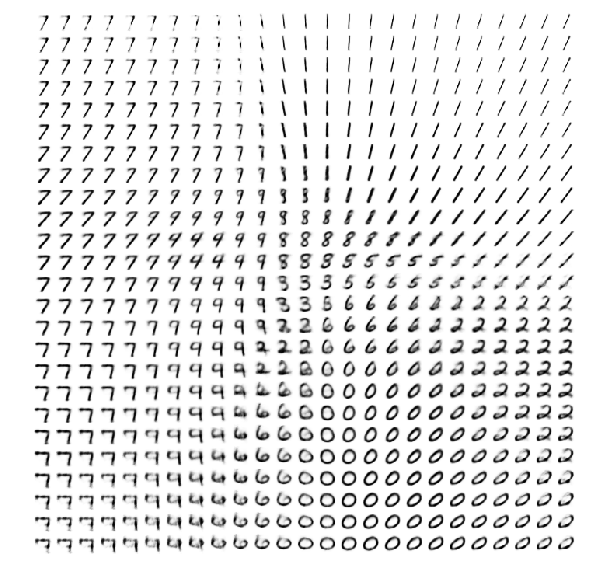

In [62]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [44]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Reds')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='GnBu')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Blues')

In [63]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [64]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>